In [2]:
# ======================================================
# STEP 0: Setup
# ======================================================

# Data handling
import pandas as pd
import numpy as np
# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
# Machine Learning - Preprocessing & Model Selection
from sklearn.model_selection import train_test_split, cross_validate, cross_val_predict
from sklearn.preprocessing import StandardScaler
# Machine Learning - Models
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
# Evaluation Metrics
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

# General Settings
import warnings
warnings.filterwarnings('ignore')

In [3]:
from datasets import load_dataset
# ======================================================
# STEP 1: Load Dataset from Hugging Face
# ======================================================
dataset = load_dataset("abhinavsarkar/delhi_air_quality_feature_store_unprocessed.csv")

In [4]:
# Hugging Face datasets are usually dicts with splits (train/test/etc.)
# If there's no split, it's just a single split named 'train'
df = dataset['train'].to_pandas()

print("Dataset Shape:", df.shape)
print(df.head())

print("\nColumns:")
print(list(df.columns))

Dataset Shape: (4468848, 15)
                                         location_id          city  \
0  Delhi Institute of Tool Engineering, Wazirpur,...      Wazirpur   
1             Satyawati College, Delhi, Delhi, India         Delhi   
2  ITI Shahdra, Jhilmil Industrial Area, Delhi, D...       Jhilmil   
3  Sonia Vihar Water Treatment Plant DJB, Delhi, ...   Sonia Vihar   
4   PGDAV College, Sriniwaspuri, Delhi, Delhi, India  Sriniwaspuri   

              event_timestamp  temperature  humidity  pressure  wind_speed  \
0  2000-03-15 13:44:28.651396       30.450    74.100   990.425       0.300   
1  2000-03-15 13:44:28.651396       26.675    74.350   980.650       1.375   
2  2000-03-15 13:44:28.651396       28.775    62.925   984.350       0.300   
3  2000-03-15 13:44:28.651396       26.575    78.525   991.300       0.300   
4  2000-03-15 13:44:28.651396       22.300    71.425   985.650       0.300   

   wind_direction   pm25   pm10   no2   so2    o3    co  aqi  
0            21.7 

In [5]:
# Rename columns
df = df.rename(columns={
    'pm25': 'PM2.5',
    'pm10': 'PM10',
    'no2': 'NO2',
    'so2': 'SO2',
    'co': 'CO',
    'o3': 'O3',
    'temperature': 'Temperature',
    'humidity': 'Humidity',
    'aqi': 'AQI'
})

Cleaned Dataset Shape: (2705899, 9)

Dataset Summary:


,count,mean,std,min,25%,50%,75%,max
Temperature,2705899.0,29.675178,3.571740,20.5,27.1,30.05,32.75,35.75
Humidity,2705899.0,59.723132,17.661146,38.3,43.7,52.95,76.50,94.00
PM2.5,2705899.0,246.813410,60.652206,170.0,198.0,235.00,280.00,467.00
PM10,2705899.0,246.027399,147.942821,109.0,159.0,186.00,271.00,930.00
NO2,2705899.0,29.312328,16.750208,5.0,17.2,27.00,35.90,90.80
SO2,2705899.0,6.862389,3.840634,0.2,3.7,7.00,9.70,20.20
CO,2705899.0,20.365261,15.088655,0.5,9.8,15.00,30.10,69.30
O3,2705899.0,28.337727,31.410063,0.5,3.3,15.60,42.30,117.80
AQI,2705899.0,280.682927,132.243504,143.0,198.0,237.00,291.00,930.00


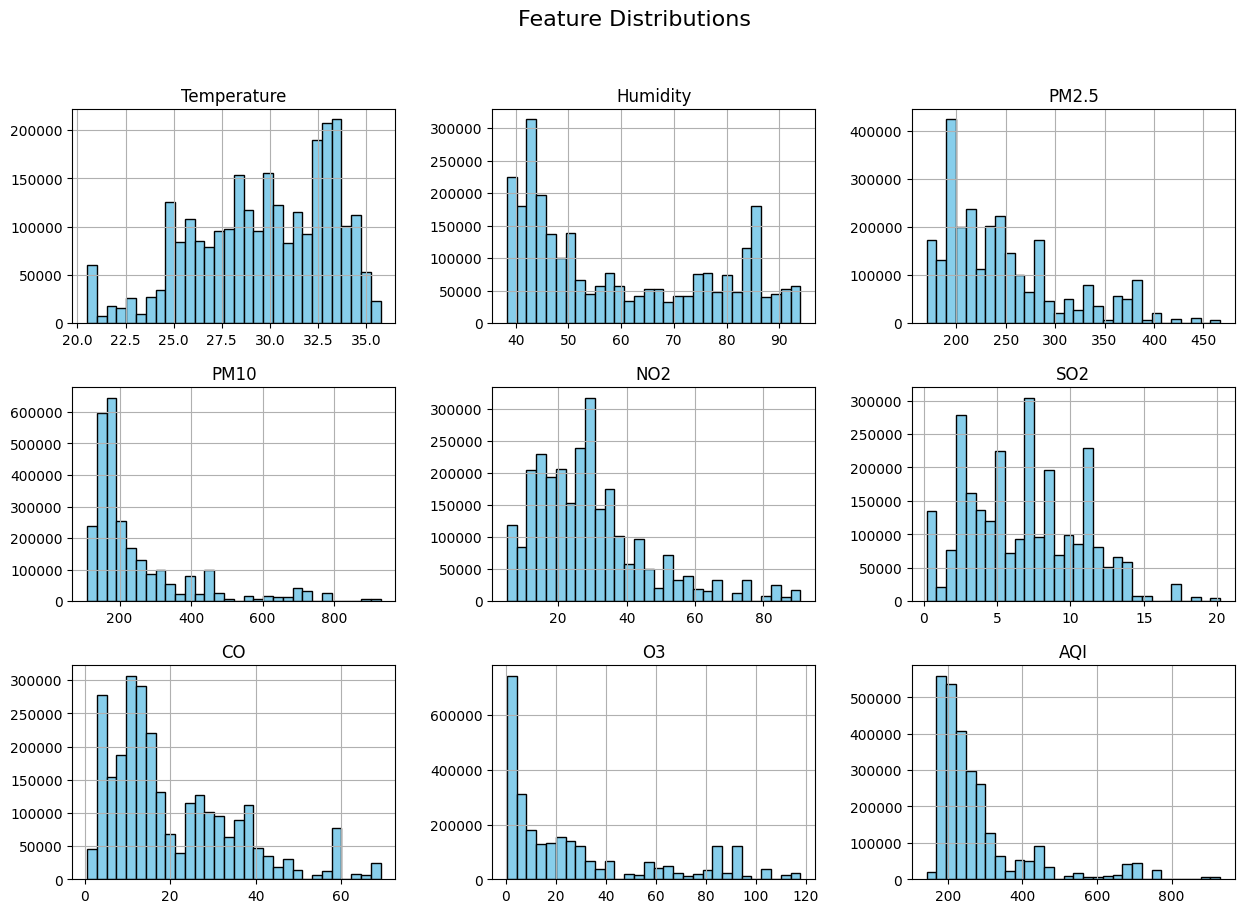

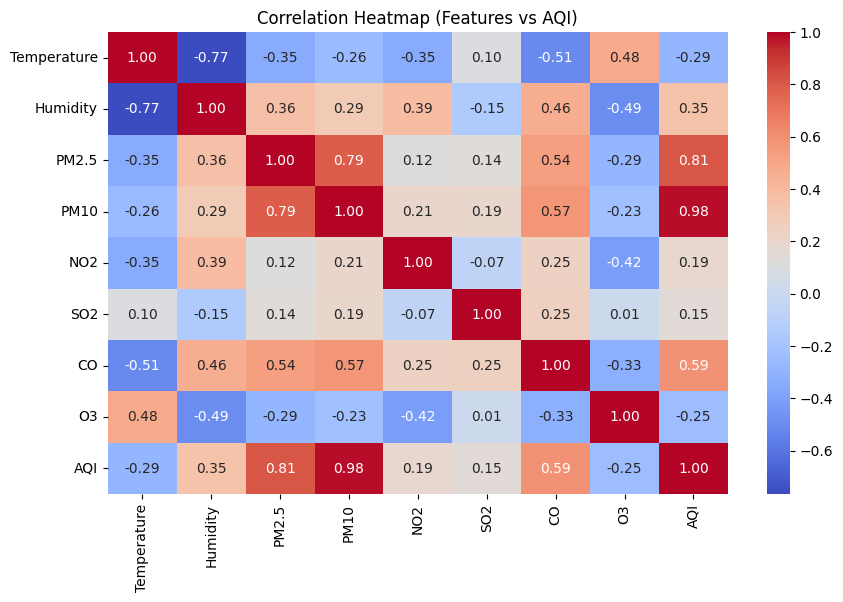

In [6]:
# ======================================================
# STEP 2: Data Cleaning & EDA
# ======================================================

# Keep only relevant columns
df = df[['Temperature','Humidity','PM2.5','PM10','NO2','SO2','CO','O3','AQI']]

# Replace "-" with NaN and convert to numeric
df.replace("-", np.nan, inplace=True)
df = df.apply(pd.to_numeric, errors="coerce")

# Drop rows with missing values
df.dropna(inplace=True)

print("Cleaned Dataset Shape:", df.shape)

# --- Summary Stats ---
print("\nDataset Summary:")
display(df.describe().T)

# --- Feature Distributions ---
df.hist(bins=30, figsize=(15,10), color="skyblue", edgecolor="black")
plt.suptitle("Feature Distributions", fontsize=16)
plt.show()

# --- Correlation Heatmap ---
plt.figure(figsize=(10,6))
sns.heatmap(df.corr(), annot=True, cmap="coolwarm", fmt=".2f", cbar=True)
plt.title("Correlation Heatmap (Features vs AQI)")
plt.show()

In [7]:
# ======================================================
# STEP 3: Data Preprocessing (70:20:10 split)
# ======================================================

# Features & target
X = df[['Temperature','Humidity','PM2.5','PM10','NO2','SO2','CO','O3']]
y = df['AQI']

# Train (70%), Validation (20%), Test (10%)
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.30, random_state=42, shuffle=True
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=(1/3), random_state=42, shuffle=True
)
# 30% * (1/3) ≈ 10% → test, 30% * (2/3) ≈ 20% → val

print(f"Train size: {len(X_train)}")
print(f"Validation size: {len(X_val)}")
print(f"Test size: {len(X_test)}")

# Standardize features (fit only on train, apply to all)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled   = scaler.transform(X_val)
X_test_scaled  = scaler.transform(X_test)


Train size: 1894129
Validation size: 541180
Test size: 270590


In [8]:
# ======================================================
# STEP 4: Train Multiple Models with Cross-Validation
# ======================================================

# --- Models ---
models = {
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(
        n_estimators=100,        
        max_depth=4,
        random_state=42
    ),
    "Gradient Boosting": GradientBoostingRegressor(
        n_estimators=100,        
        learning_rate=0.1,       # smaller steps for stability
        max_depth=2,             # trees not too deep
        random_state=42
    )
}

results = {}

for name, model in models.items():
    # Use scaled data only for Linear Regression
    X_data = X_train_scaled if name == "Linear Regression" else X_train
    
    # Cross-validated predictions
    y_pred = cross_val_predict(model, X_data, y_train, cv=5)
    
    # Metrics
    r2  = r2_score(y_train, y_pred)
    mae = mean_absolute_error(y_train, y_pred)
    rmse = np.sqrt(mean_squared_error(y_train, y_pred))
    
    # Save results
    results[name] = {"R2": r2, "MAE": mae, "RMSE": rmse}
    
    # Print
    print(f"\n{name} Results:")
    print("  R2   :", round(r2, 3))
    print("  MAE  :", round(mae, 3))
    print("  RMSE :", round(rmse, 3))



Linear Regression Results:
  R2   : 0.978
  MAE  : 15.413
  RMSE : 19.48

Random Forest Results:
  R2   : 0.989
  MAE  : 10.082
  RMSE : 14.015

Gradient Boosting Results:
  R2   : 0.998
  MAE  : 3.735
  RMSE : 6.459


In [24]:
# ======================================================
# STEP 5: Evaluate Models on Validation & Test Sets
# ======================================================

models = {
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(
        n_estimators=100, max_depth=5,
        min_samples_split=5, min_samples_leaf=3,
        random_state=42
    ),
    "Gradient Boosting": GradientBoostingRegressor(
        n_estimators=100, max_depth=2,
        min_samples_split=5, min_samples_leaf=3,
        random_state=42
    )
}

for name, model in models.items():
    # Scale only for Linear Regression
    X_tr = X_train_scaled if name == "Linear Regression" else X_train
    X_val_data = X_val_scaled if name == "Linear Regression" else X_val
    X_test_data = X_test_scaled if name == "Linear Regression" else X_test
    
    # Train
    model.fit(X_tr, y_train)
    
    # Validation performance
    y_val_pred = model.predict(X_val_data)
    r2_val = r2_score(y_val, y_val_pred)
    mae_val = mean_absolute_error(y_val, y_val_pred)
    rmse_val = np.sqrt(mean_squared_error(y_val, y_val_pred))
    
    # Test performance
    y_test_pred = model.predict(X_test_data)
    r2_test = r2_score(y_test, y_test_pred)
    mae_test = mean_absolute_error(y_test, y_test_pred)
    rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))
    
    print(f"\n{name}:")
    print(f"  Validation -> R²: {r2_val:.3f}, MAE: {mae_val:.3f}, RMSE: {rmse_val:.3f}")
    print(f"  Test       -> R²: {r2_test:.3f}, MAE: {mae_test:.3f}, RMSE: {rmse_test:.3f}")



Linear Regression:
  Validation -> R²: 0.978, MAE: 15.429, RMSE: 19.515
  Test       -> R²: 0.978, MAE: 15.422, RMSE: 19.497

Random Forest:
  Validation -> R²: 0.995, MAE: 5.889, RMSE: 9.067
  Test       -> R²: 0.995, MAE: 5.871, RMSE: 9.029

Gradient Boosting:
  Validation -> R²: 0.998, MAE: 3.724, RMSE: 6.304
  Test       -> R²: 0.998, MAE: 3.728, RMSE: 6.302



Model Comparison:
                         R2        MAE       RMSE
Linear Regression  0.978279  15.412908  19.480388
Random Forest      0.995349   5.857147   9.013774
Gradient Boosting  0.997612   3.734882   6.458804


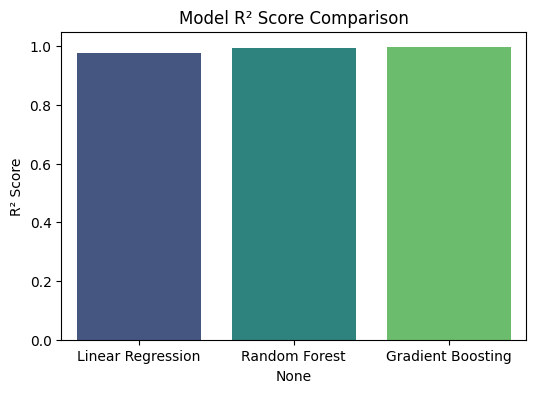

In [25]:
# ======================================================
# STEP 5: Compare Models Side by Side
# ======================================================

# Convert results dict into DataFrame
results_df = pd.DataFrame(results).T

# If any metrics are arrays (e.g. CV folds), take mean
results_df = results_df.applymap(
    lambda x: np.mean(x) if isinstance(x, (list, np.ndarray)) else x
)

# Rename columns for easier access
results_df = results_df.rename(columns={
    "Average R²": "R2",
    "Average MAE": "MAE",
    "Average RMSE": "RMSE"
})

print("\nModel Comparison:")
print(results_df[["R2", "MAE", "RMSE"]])

# Barplot of R² scores
plt.figure(figsize=(6,4))
sns.barplot(x=results_df.index, y=results_df['R2'], palette="viridis")
plt.title("Model R² Score Comparison")
plt.ylabel("R² Score")
plt.ylim(0, 1.05)   # keep it bounded nicely
plt.show()


Best Model: Gradient Boosting


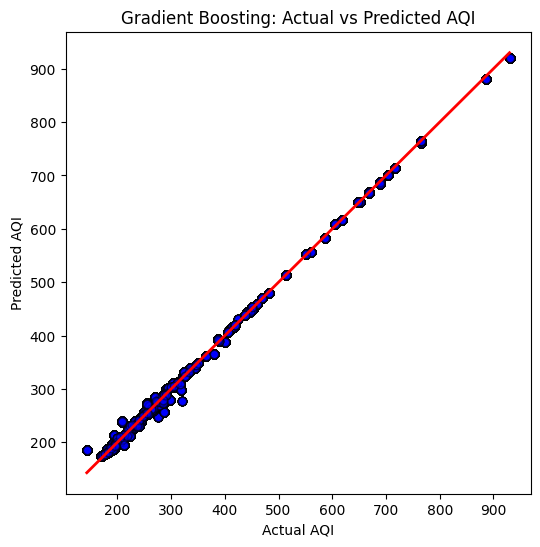

In [27]:
# ======================================================
# STEP 6: Visualize Predictions
# ======================================================

# --- Pick the best model (highest R²) ---
best_model_name = results_df["R2"].idxmax()
print("\nBest Model:", best_model_name)

# --- Train the best model on full training data ---
if best_model_name == "Linear Regression":
    best_model = LinearRegression()
    best_model.fit(X_train_scaled, y_train)
    y_pred_best = best_model.predict(X_test_scaled)
elif best_model_name == "Random Forest":
    best_model = RandomForestRegressor(
        n_estimators=100, max_depth=5,
        min_samples_split=5, min_samples_leaf=3,
        random_state=42
    )
    best_model.fit(X_train, y_train)
    y_pred_best = best_model.predict(X_test)
elif best_model_name == "Gradient Boosting":
    best_model = GradientBoostingRegressor(
        n_estimators=100, max_depth=2,
        min_samples_split=5, min_samples_leaf=3,
        random_state=42
    )
    best_model.fit(X_train, y_train)
    y_pred_best = best_model.predict(X_test)

# --- Scatter plot: Actual vs Predicted AQI ---
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred_best, alpha=0.5, color="blue", edgecolor="k")
plt.xlabel("Actual AQI")
plt.ylabel("Predicted AQI")
plt.title(f"{best_model_name}: Actual vs Predicted AQI")
plt.plot(
    [y_test.min(), y_test.max()],
    [y_test.min(), y_test.max()],
    color="red", linewidth=2
)  # ideal diagonal line
plt.show()

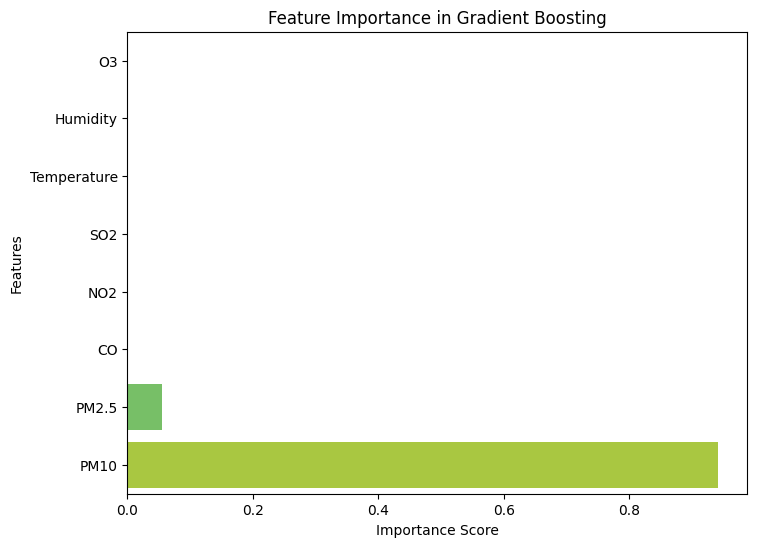

In [29]:
# ======================================================
# STEP 7: Feature Importance
# ======================================================

if best_model_name in ["Random Forest", "Gradient Boosting"]:
    # Tree-based models → feature_importances_
    importances = best_model.feature_importances_
    feature_names = X_train.columns

    feat_imp = pd.Series(importances, index=feature_names).sort_values(ascending=True)

    plt.figure(figsize=(8,6))
    sns.barplot(x=feat_imp, y=feat_imp.index, palette="viridis")
    plt.title(f"Feature Importance in {best_model_name}")
    plt.xlabel("Importance Score")
    plt.ylabel("Features")
    plt.show()

elif best_model_name == "Linear Regression":
    # Linear model → coefficients (absolute value = importance strength)
    coefs = np.abs(best_model.coef_)
    feature_names = X_train.columns

    feat_imp = pd.Series(coefs, index=feature_names).sort_values(ascending=True)

    plt.figure(figsize=(8,6))
    sns.barplot(x=feat_imp, y=feat_imp.index, palette="coolwarm")
    plt.title("Feature Importance in Linear Regression (by coefficient magnitude)")
    plt.xlabel("Coefficient Magnitude")
    plt.ylabel("Features")
    plt.show()

else:
    print(f"\nFeature importance not available for {best_model_name}.")

In [32]:
# ======================================================
# STEP 8: What-If Simulation
# ======================================================

# Pick a sample from test data
sample = X_test.iloc[0].copy()

print("\nOriginal Sample Input:")
print(sample)

# Reduce PM2.5 by 20%
sample_reduced = sample.copy()
sample_reduced["PM2.5"] *= 0.8

print("\nModified Sample Input (20% PM2.5 reduction):")
print(sample_reduced)

# Convert to DataFrame for prediction
sample_df = pd.DataFrame([sample])
sample_reduced_df = pd.DataFrame([sample_reduced])

# Predict with scaling if Linear Regression
if best_model_name == "Linear Regression":
    orig_pred = best_model.predict(scaler.transform(sample_df))[0]
    new_pred  = best_model.predict(scaler.transform(sample_reduced_df))[0]
else:
    orig_pred = best_model.predict(sample_df)[0]
    new_pred  = best_model.predict(sample_reduced_df)[0]

print(f"\nOriginal AQI Prediction: {orig_pred:.2f}")
print(f"New AQI Prediction (after 20% PM2.5 reduction): {new_pred:.2f}")
print(f"Improvement: {orig_pred - new_pred:.2f} AQI points")


Original Sample Input:
Temperature     32.7
Humidity        41.7
PM2.5          200.0
PM10           181.0
NO2             13.6
SO2              2.9
CO               6.8
O3              92.7
Name: 2215572, dtype: float64

Modified Sample Input (20% PM2.5 reduction):
Temperature     32.7
Humidity        41.7
PM2.5          160.0
PM10           181.0
NO2             13.6
SO2              2.9
CO               6.8
O3              92.7
Name: 2215572, dtype: float64

Original AQI Prediction: 208.46
New AQI Prediction (after 20% PM2.5 reduction): 190.44
Improvement: 18.02 AQI points
